In [87]:
import os
import math
import time
import numpy
import pandas
import random
import matplotlib
import numpy.random as nrand
import matplotlib.pylab as plt
from sklearn import preprocessing 

class Datum:
    def __init__(self, data,indice):
        """
        A Datum object is basically just a ND vector
        :param data: the ND vector
        """
        self.data   = data
        self.indice = indice
        self.classe  = 0

    def similarity(self, datum,vmax = 1.85 ,alpha = 1.5):
        """
        Returns the sum-squared distance between this datum and some other datum
        :param datum: the other datum
        :return: sum squared distance
        """
        diff = numpy.abs(self.data - datum.data)
        distance = math.sqrt(numpy.sum(numpy.power(diff,2)))
        v = (vmax-1) * numpy.random.random() + 1 
        return 1-(distance/(alpha*(1+(v-1)/vmax)))

    def condense(self):
        """
        A method for condensing ND into 1D for visualization ... many options exist for this
        :return: the 1D representation of the vector
        """
        return numpy.mean(self.data)

class Ant:
    def __init__(self, y, x, grid):
        """
        This initializes an ant object. This Ant class is just a dumb ant with no memory
        :param y: the y location it is initialized to
        :param x: the x location it is initialized to
        :param grid: a reference to the grid
        """
        self.loc = numpy.array([y, x])
        self.carrying = grid.get_grid()[y][x]
        self.grid = grid

    def move(self, n, c):
        """
        A recursive function for making ants move around the grid
        :param step_size: the size of each step
        """
        
        step_size = random.randint(1, 25)
        # Add some vector (-1,+1) * step_size to the ants location
        self.loc += nrand.randint(-1 * step_size, 1 * step_size, 2)
        # Mod the new location by the grid size to prevent overflow
        self.loc = numpy.mod(self.loc, self.grid.dim)
        # Get the object at that location on the grid
        o = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        # If the cell is occupied, move again
        if o is not None:
            # If the ant is not carrying an object
            if self.carrying is None:
                # Check if the ant picks up the object
                if self.p_pick_up(n, c) >= random.random():
                    # Pick up the object and rem from grid
                    self.carrying = o
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = None
                # If not then move
                else:
                    self.move(n, c)
            # If carrying an object then just move
            else:
                self.move(n, c)
        # If on an empty cell
        else:
            if self.carrying is not None:
                # Check if the ant drops the object
                if self.p_drop(n, c) >= random.random():
                    # Drop the object at the empty location
                    o = self.carrying
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = o
                    self.grid.data[o.indice][0] = self.loc[0]
                    self.grid.data[o.indice][1] = self.loc[1]
                    self.carrying = None

    def p_pick_up(self, n, c):
        """
        Returns the probability of picking up an object
        :param n: the neighbourhood size
        :return: probability of picking up
        """
        ant = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        return 1 - self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)

    def p_drop(self, n, c):
        """
        Returns the probability of dropping an object
        :return: probability of dropping
        """
        ant = self.carrying
        return self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)

class Grid:
    def __init__(self, height, width, path,vmax = 1.85 ,alpha = 1.5):
        """
        This method initializes a grid object. A grid is basically just a 2D array of Datum objects
        :param height: this is the height of the grid
        :param width: this is the width of the grid
        """
        self.path = path
        # Store the dimensions of the grid
        self.dim = numpy.array([height, width])
        # Initialize an empty numpy matrix of type Datum
        self.grid = numpy.empty((height, width), dtype=Datum)
        #speed and alpha 
        self.vmax = vmax
        self.alpha = alpha 
        #data a table that contains the (x,y) for the object i  
        self.data  = None
        # This makes the plot redraw
        plt.ion()
        plt.figure(figsize=(100, 100))
        self.max_d = 0.001
        
    def fill_grid(self,data):
        i = 0; 
        self.data = numpy.empty((data.shape[0],2))
        for i in range(data.shape[0]):
            ux = random.randint(0, self.dim[1] - 1);
            uy = random.randint(0, self.dim[0] - 1);
            
            while (self.grid[uy][ux] is not None):
                ux = random.randint(0, self.dim[1] - 1);
                uy = random.randint(0, self.dim[0] - 1);
            self.grid[uy][ux] = Datum(data[i,:],i); 
            self.data[i][0] = int(uy)
            self.data[i][1] = int(ux)
    
    def matrix_grid(self):
        """
        This method condenses the grid (2D array of Datum objects) to a matrix which can be visualized
        :return: matrix of the grid
        """
        matrix = numpy.empty((self.dim[0], self.dim[1]))
        matrix.fill(0)
        for y in range(self.dim[0]):
            for x in range(self.dim[1]):
                if self.grid[y][x] is not None:
                    matrix[y][x] = self.get_grid()[y][x].classe
                else:
                    matrix[y][x] = 0 
        return matrix

    def plot_grid(self, name="first", save_figure=False):
        """
        This plots the 2D representation of the grid
        :param name: the name of the image to save
        :return:
        """
        plt.figure(figsize=(100, 100))
        plt.matshow(self.matrix_grid(), fignum=0)
        # Option to save images
        if save_figure:
            plt.savefig(self.path + name + '.png')
        # plt.draw()

    def get_grid(self):
        return self.grid

    def get_probability(self, d, y, x, n, c):
        """
        This gets the probability of drop / pickup for any given Datum, d
        :param d: the datum
        :param x: the x location of the datum / ant carrying datum
        :param y: the y location of the datum / ant carrying datum
        :param n: the size of the neighbourhood function
        :param c: constant for convergence control
        :return: the probability of
        """
        # Starting x and y locations
        y_s = y - n
        x_s = x - n
        total = 0.0
        # For each neighbour
        for i in range((n*2)+1):
            xi = (x_s + i) % self.dim[0]
            for j in range((n*2)+1):
                # If we are looking at a neighbour
                yj = (y_s + j) % self.dim[1]
                if xi != x and yj != y:
                    # Get the neighbour, o
                    o = self.grid[yj][xi]
                    # Get the similarity of o to x
                    if o is not None:
                        s = d.similarity(o,vmax= self.vmax,alpha = self.alpha)
                        total += s
        # Normalize the density by the max seen distance to date
        md = total / (math.pow(n, 2))
        density = max(md, 0)
        t = math.exp(-c * density)
        probability = (1-t)/(1+t)
        return probability

def optimize(X,height, width, ants, sims, n, c, freq=500, path="image"):
    """
    Main method for running the algorithm
    """
    # Initialize the grid
    grid = Grid(height, width,path,vmax = 1.85,alpha = 1.5)
    grid.fill_grid(data=X)
    # Create the ants
    ant_agents = []
    for i in range(ants):
        ant = Ant(random.randint(0, height - 1), random.randint(0, width - 1), grid)
        ant_agents.append(ant)
    for i in range(sims):
        for ant in ant_agents:
            ant.move(n, c)
        if i % freq == 0 :
            print(i)
    #try to drop all objects in the grid when it is possible 
    for ant in ant_agents:
        while ant.carrying is not None : 
            ant.move(n, c) 
    results = labeling_objects(grid = grid, neighborhood_distance = 10, minimal_neighbors = 2)
    return results
            
def labeling_objects (grid, neighborhood_distance, minimal_neighbors):
    """
    This method gives foreach object in the grid a classe according to 
    its neighbors. 
    :param grid: the grid
    :param neighborhood_distance: the maximal distance between two neighbors 
    :param minimal_neighbors: minimal number of neighbors to not be classifed as outlier (isolited)
    """
    # foreach occupied point (x,y), we search in the neighborhood ( x-n -> x+n , y-n -> y+n ) 
    # to find the right classe for our object in (x,y)
    n = neighborhood_distance; 
    c = 0  #used to create new classe 
    for i in range(grid.data.shape[0]):
        y = int(grid.data[i][0])
        x = int(grid.data[i][1])
        if grid.grid[y][x] is not None:
                if (grid.grid[y][x].classe == 0):
                    grid.grid[y][x].classe = c+1 
                    c+=1
                y_s = y - n
                x_s = x - n
                # For each neighbour
                neighbors = 0
                for i in range((n*2)+1):
                    xi = (x_s + i) % grid.dim[1]
                    for j in range((n*2)+1):
                        yj = (y_s + j) % grid.dim[0]
                        # If we are looking at a neighbour
                        if xi != x and yj != y:
                            o = grid.grid[yj][xi]
                            if o is not None:
                                neighbors += 1 
                                if o.classe == 0:
                                    grid.grid[yj][xi].classe = grid.grid[y][x].classe
                if neighbors == 0:
                    grid.grid[y][x].classe = -1
                    c-=1    
    return {
        "number_classes": c,
        "grid": grid
    }

In [88]:
dataset1 = pandas.read_csv('iris.data', sep=",", header=None)

X_train = dataset1.iloc[:, :-1].values # Premières colonnes 
Y_train = dataset1.iloc[:,-1].values # Dernière colonne
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


In [106]:
results = optimize(X = X_scaled,height= 60, 
                   width = 60, ants = 25, sims = 150000, n = 3, c = 3, freq=1000, path="image")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000


<Figure size 7200x7200 with 0 Axes>

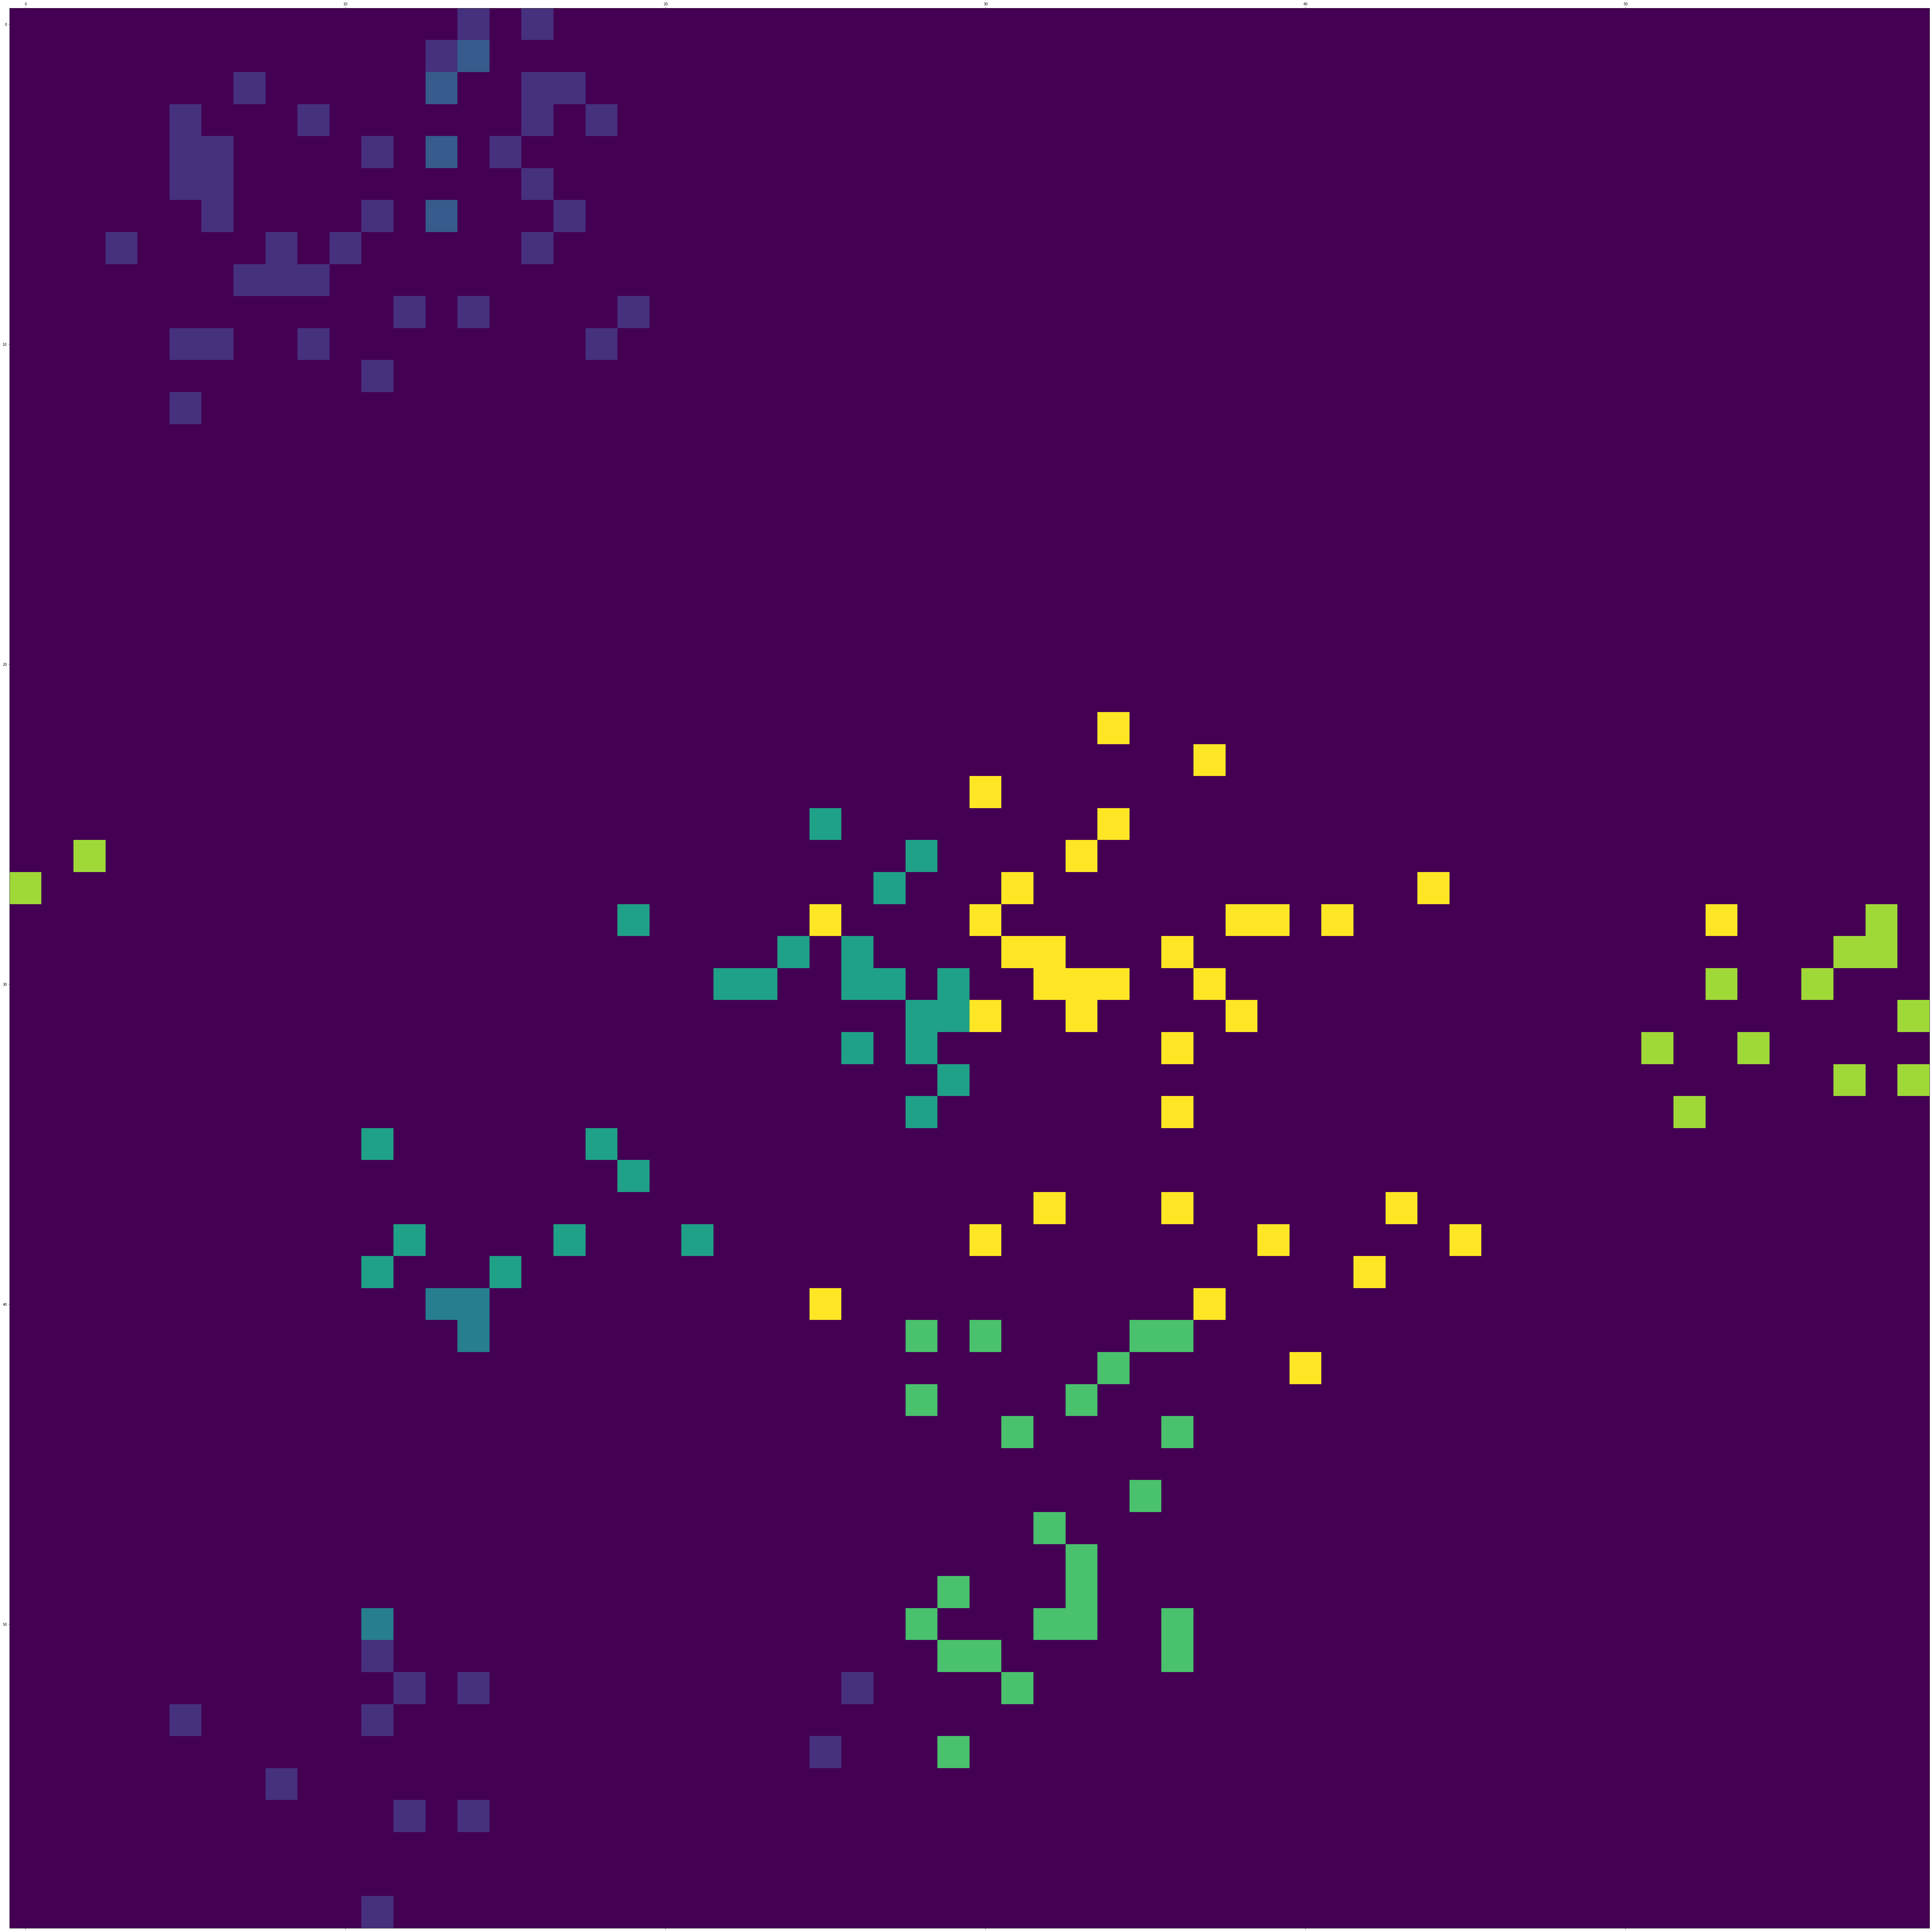

In [107]:
results['grid'].plot_grid()

In [108]:
results

{'number_classes': 7, 'grid': <__main__.Grid at 0x1ef1677ba90>}